In [4]:
import numpy as np
from scipy.stats import nbinom, rv_discrete, poisson, truncnorm
from scipy.special import erf
import matplotlib.pyplot as plt
from typing import List, Union
import classmethod

ModuleNotFoundError: No module named 'classmethod'

In [6]:
class DiscreteConflation:
    """A conflation of discrete random variables, as described in https://www.researchgate.net/publication/1747728_Conflations_of_Probability_Distributions.
    
    Given discrete random variables X_1, X_2, ..., X_n, with pmfs g_{X_1}, g_{X_2}, ..., g_{X_n}, the conflation Q = X_1 & X_2 & ... & X_n has pmf given by

        g_Q(y) = (1 / Z) * g_{X_1}(y) * g_{X_2}(y) * ... * g_{X_n}(y)
        
    where Z is a normalizing constant so the masses sum to 1. This is a proper random variable with certain desirable properties for combining distributions.

    Args:
        random_variables (list(rv_discrete)): A list of the discrete random variables to conflate (i.e. X_1, X_2, ..., X_n)
        support (np.ndarray): An array describing the support of the conflation (should be discrete). This should be the intersection of the support of X_1, ..., X_n.
    """

    def __init__(self, random_variables: List[rv_discrete], support: np.ndarray):
        self.random_variables = random_variables
        self.support = support
        self._fit()

    def _fit(self):
        """Precompute the pmf of this discrete conflation over the entire support."""
        running_product = np.ones_like(self.support, dtype=float)
        for rv in self.random_variables:
            running_product *= rv.pmf(self.support)

        self.unnormalized_mass = running_product
        self.Z = running_product.sum()
        self.mass = self.unnormalized_mass / self.Z

    def pmf(self, x: Union[int, np.ndarray]) -> Union[float, np.ndarray]:
        """Calculate the probability that this conflation takes on the value(s) x.
        
        Args:
            x (int | np.ndarray): The value(s) to compute the probability of.
        """
        if x not in self.support:
            raise ValueError(f"Provided value {x} is not in the support of this random variable.")
        
        return self.mass[np.where(self.support == x)]
    
class DiscreteTruncatedNormal:
    """A discrete truncated normal random variable.
    
    This random variable has support [lower_bound, upper_bound] \intersect \mathbb{Z}.
    If X ~ DiscreteTruncatedNormal(lower_bound, upper_bound, mu, sigma), then let a = (lower_bound - mu) / sigma, b = (upper_bound - mu) / sigma, and
        let Y ~ TruncatedNormal(a, b, mu, sigma) have pdf f_Y. Then the pmf of X is given by P(X = x) = (1/Z) * f_Y(x) (where Z is a normalizing constant).

    Args:
        lower_bound (int): The lowest value the DiscreteTruncatedNormal random variable can take.
        upper_bound (int): The highest value the DiscreteTruncatedNormal random variable can take.
        mu (float, int): The mean of the truncated normal distribution that will be used to compute unnormalized densities.
        sigma (float, int): The standard deviation of the truncated normal distribution that will be used to compute unnormalized densities.
    """
    def __init__(self, lower_bound: int, upper_bound: int, mu: Union[float, int], sigma: Union[float, int]):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.mu = mu
        self.sigma = sigma
        self.a, self.b = (lower_bound - mu) / sigma, (upper_bound - mu) / sigma
        self.base_rv = truncnorm(loc=mu, scale=sigma, a=self.a, b=self.b)
        self.support = np.arange(lower_bound, upper_bound)
        self.Z = self.base_rv.pdf(self.support).sum()

    def pmf(self, x: Union[int, np.ndarray]) -> Union[float, np.ndarray]:
        """Calculate the probability that this random variable takes on the value(s) x.
        
        Args:
            x (int | np.ndarray): The value(s) to compute the probability of.
        """
        return self.base_rv.pdf(x) / self.Z
    
    def negative_log_likelihood(self, x: Union[int, np.ndarray]) -> Union[float, np.ndarray]:
        """Calculate the negative log likelihood of x for this random variable.
        
        Args:
            x (int | np.ndarray): The value(s) to compute the negative log likelihood of.
        """
        return (
            0.5 * ((x - self.mu) / self.sigma)**2 +
            np.log(self.sigma) +
            np.log(erf((self.b - self.mu)/ (self.sigma * np.sqrt(2))) - erf((self.a - self.mu) / (self.sigma * np.sqrt(2))))
        )

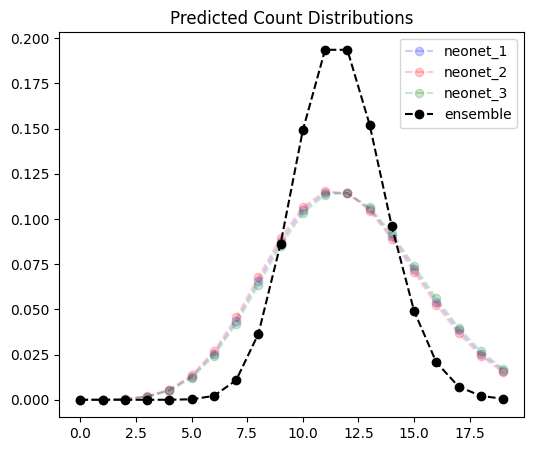

In [7]:
# Conflation of three poissons.

lambda_vals = [12.0, 11.9, 12.1]
support = np.arange(0, 20)

neonet_1 = poisson(lambda_vals[0])
neonet_2 = poisson(lambda_vals[1])
neonet_3 = poisson(lambda_vals[2])
ensemble = DiscreteConflation([neonet_1, neonet_2, neonet_3], support)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title("Predicted Count Distributions")
ax.plot(support, neonet_1.pmf(support), color='blue', marker='o', alpha=0.2,label='neonet_1', linestyle='--')
ax.plot(support, neonet_2.pmf(support), color='red', marker='o', alpha=0.2, label='neonet_2', linestyle='--')
ax.plot(support, neonet_3.pmf(support), color='green', marker='o', alpha=0.2, label='neonet_3', linestyle='--')
ax.plot(support, ensemble.pmf(support), color='black', marker='o', label='ensemble', linestyle='--')
ax.legend()

plt.show()

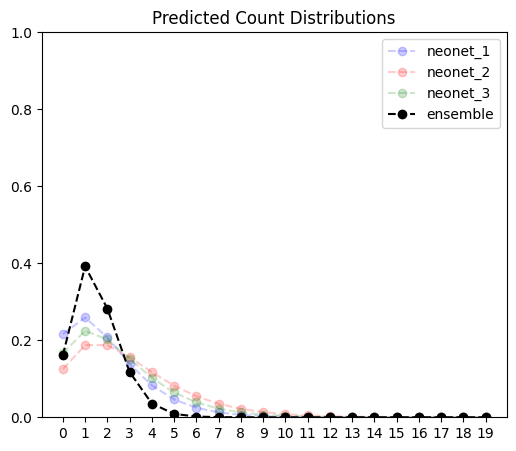

In [8]:
# Conflation of three negative binomials.

n = 3
p_vals = [0.6, 0.5, 0.55]
support = np.arange(0, 20)

neonet_1 = nbinom(n=n, p=p_vals[0])
neonet_2 = nbinom(n=n, p=p_vals[1])
neonet_3 = nbinom(n=n, p=p_vals[2])
ensemble = DiscreteConflation([neonet_1, neonet_2, neonet_3], support)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title("Predicted Count Distributions")
ax.plot(support, neonet_1.pmf(support), color='blue', marker='o', alpha=0.2,label='neonet_1', linestyle='--')
ax.plot(support, neonet_2.pmf(support), color='red', marker='o', alpha=0.2, label='neonet_2', linestyle='--')
ax.plot(support, neonet_3.pmf(support), color='green', marker='o', alpha=0.2, label='neonet_3', linestyle='--')
ax.plot(support, ensemble.pmf(support), color='black', marker='o', label='ensemble', linestyle='--')
ax.set_xticks(support)
ax.set_ylim(0, 1)
ax.legend()

plt.show()

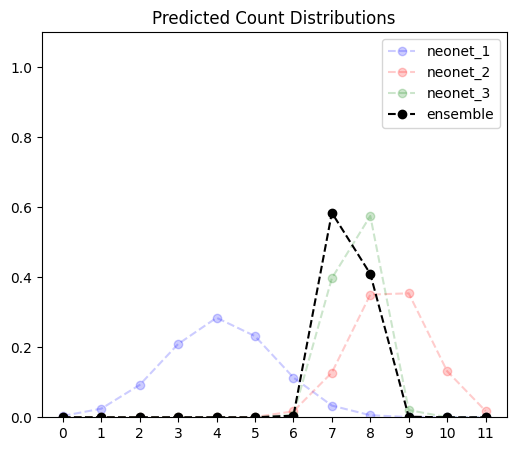

In [10]:
lower_bound, upper_bound = 0, 12
mu_vals = [4.1, 8.51, 7.6]
sigma_vals = [1.4, 1.0, 0.52]
support = np.arange(lower_bound, upper_bound)

neonet_1 = DiscreteTruncatedNormal(lower_bound, upper_bound, mu_vals[0], sigma_vals[0])
neonet_2 = DiscreteTruncatedNormal(lower_bound, upper_bound, mu_vals[1], sigma_vals[1])
neonet_3 = DiscreteTruncatedNormal(lower_bound, upper_bound, mu_vals[2], sigma_vals[2])
ensemble = DiscreteConflation([neonet_1, neonet_2, neonet_3], support)


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title("Predicted Count Distributions")
ax.plot(support, neonet_1.pmf(support), color='blue', marker='o', alpha=0.2,label='neonet_1', linestyle='--')
ax.plot(support, neonet_2.pmf(support), color='red', marker='o', alpha=0.2, label='neonet_2', linestyle='--')
ax.plot(support, neonet_3.pmf(support), color='green', marker='o', alpha=0.2, label='neonet_3', linestyle='--')
ax.plot(support, ensemble.pmf(support), color='black', marker='o', label='ensemble', linestyle='--')
ax.set_xticks(support)
ax.set_ylim(0, 1.1)
ax.legend()

plt.show()

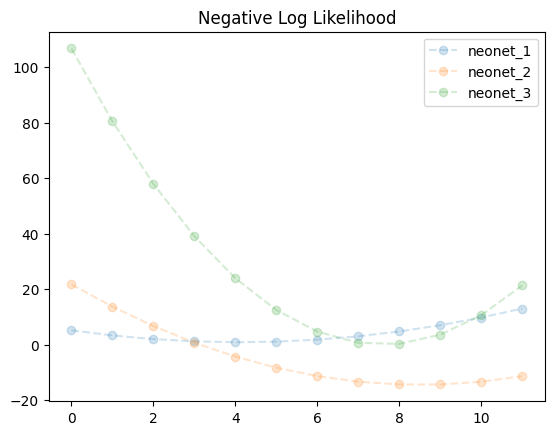

In [11]:
plt.title("Negative Log Likelihood")
plt.plot(support, neonet_1.negative_log_likelihood(support), label='neonet_1', marker='o', linestyle='--', alpha=0.2)
plt.plot(support, neonet_2.negative_log_likelihood(support), label='neonet_2', marker='o', linestyle='--', alpha=0.2)
plt.plot(support, neonet_3.negative_log_likelihood(support), label='neonet_3', marker='o', linestyle='--', alpha=0.2)
plt.legend()
plt.show()